In [144]:
import numpy as np
import nibabel as nib 
import glob
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
from tifffile import imsave 
from sklearn.preprocessing import MinMaxScaler 
import os 
import random
import splitfolders

# Handling the Dataset

### Dealing with one training Example

In [38]:
TRAIN_DATASET_PATH = "BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

test_subject  = list() # for the different modalities  
for file in os.listdir(TRAIN_DATASET_PATH + '\BraTS20_Training_001'): 
    file_path = os.path.join(TRAIN_DATASET_PATH + '\BraTS20_Training_001', file) 
    curr_image = nib.load(file_path) 
    test_subject.append((file, curr_image.get_fdata())) 

In [39]:
for modality, image in test_subject:
    print(f'modality type: {modality}, image_shape {image.shape}, max value (scale check): {(image.min(),image.max())}')

modality type: BraTS20_Training_001_flair.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 625.0)
modality type: BraTS20_Training_001_seg.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 4.0)
modality type: BraTS20_Training_001_t1.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 678.0)
modality type: BraTS20_Training_001_t1ce.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 1845.0)
modality type: BraTS20_Training_001_t2.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 376.0)


In [54]:
scalar = MinMaxScaler() # to overcome the scalar variance
rescaled_subject_test = list()
for modality,image in test_subject:   
    if modality != "BraTS20_Training_001_seg.nii": # avoid adjusting the mask 
        rescaled_image = scalar.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape) # fit_transform doesn't work on 3D 
        rescaled_subject_test.append(rescaled_image)
    else:
        mask_image = image.astype(np.uint8) # save a some memory 
        rescaled_subject_test.append(mask_image) # just the mask

In [55]:
for image in rescaled_subject_test:
    print(f'max value (scale check): {(image.min(),image.max())}') 
# ready to preceed :) 

max value (scale check): (0.0, 1.0)
max value (scale check): (0, 4)
max value (scale check): (0.0, 1.0)
max value (scale check): (0.0, 1.0)
max value (scale check): (0.0, 1.0)


In [141]:
# the mask values 
print(f"The labels we have: {np.unique(rescaled_subject_test[1].reshape(-1, 1))}") 
val, counts = np.unique(rescaled_subject_test[1].reshape(-1, 1), return_counts=True)
print(val, counts) # this can be used later on the reject useless data (useless in this context mean has less important data)

The labels we have: [0 1 2 3]
[0 1 2 3] [8716021   15443  168794   27742]


It seems that there are some missed labels, especifically label **3**, so reassign each 4-valued label to 3

In [58]:
rescaled_subject_test[1][rescaled_subject_test[1] == 4] = 3 

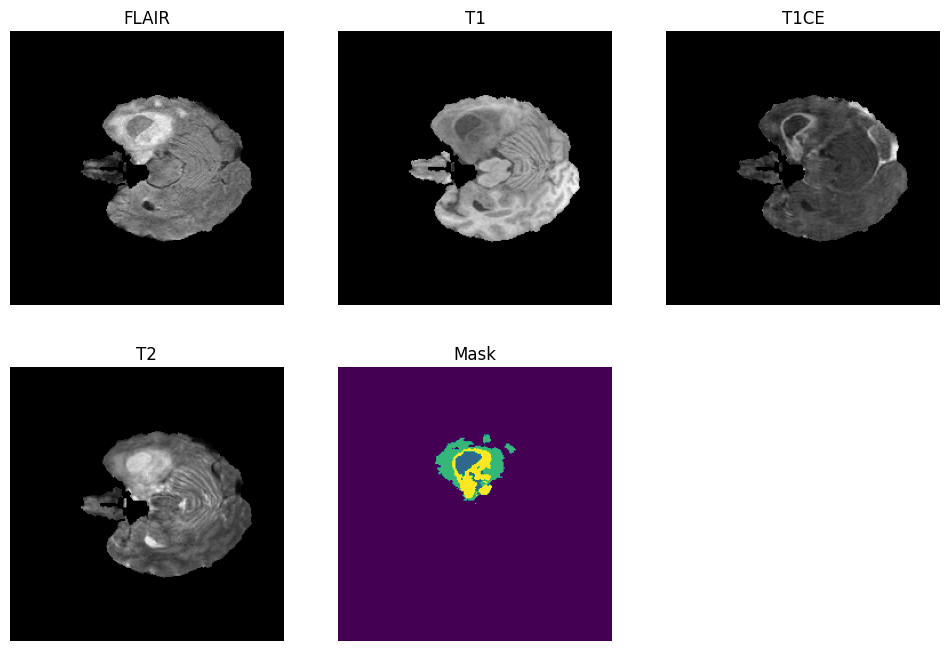

In [82]:
selected_slice = random.randint(0, rescaled_subject_test[0].shape[-1])

plt.figure(figsize=(12,8))

plt.subplot(231) 
plt.imshow(rescaled_subject_test[0][:,:,selected_slice], cmap="gray")
plt.title("FLAIR")
plt.axis("off")
plt.subplot(232) 
plt.imshow(rescaled_subject_test[2][:,:,selected_slice], cmap="gray")
plt.title("T1")
plt.axis("off")
plt.subplot(233) 
plt.imshow(rescaled_subject_test[3][:,:,selected_slice], cmap="gray")
plt.title("T1CE")
plt.axis("off")
plt.subplot(234) 
plt.imshow(rescaled_subject_test[4][:,:,selected_slice], cmap="gray")
plt.title("T2")
plt.axis("off")
plt.subplot(235) 
plt.imshow(rescaled_subject_test[1][:,:,selected_slice])
plt.title("Mask")
plt.axis("off");

Worth noting that most of volumes are useless in the sense that they just add on a redundant computational cost, we need to handle this problem later on to save us wasting resources.  

In [95]:
# stacking all these volumns together to use it later one in the training process 
combined_subject_data = np.stack([rescaled_subject_test[0], rescaled_subject_test[2], rescaled_subject_test[3], rescaled_subject_test[4]], axis= 3) 
print(f'The size before cropping: {combined_subject_data.shape}') 
# in order to get rid of the redundant data exists we need to crop the volume and make it of order of 2 to accelerate the computation 
print(f"[{(240 - 128)//2}, {(240 - 128)//2}, {(155 - 128)//2}]") 
cropped_subject_data = combined_subject_data[56:(240-56),56:(240-56),13:(155-14)]  # depth is of odd size 
print(f'The size before cropping: {cropped_subject_data.shape}')

The size before cropping: (240, 240, 155, 4)
[56, 56, 13]
The size before cropping: (128, 128, 128, 4)


In [97]:
# same is done for the mask 
subject_mask = rescaled_subject_test[1][56:(240-56),56:(240-56),13:(155-14)]
print(f"the mask size: {subject_mask.shape}") 

the mask size: (128, 128, 128)


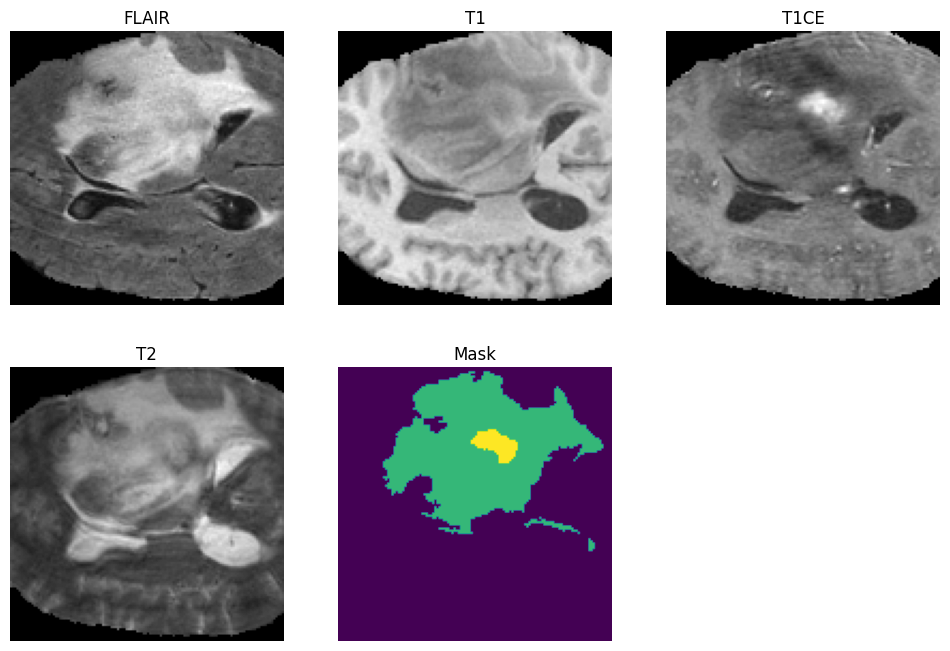

In [118]:
selected_slice = random.randint(0, 128)

plt.figure(figsize=(12,8))

plt.subplot(231) 
plt.imshow(cropped_subject_data[:,:,selected_slice,0], cmap="gray")
plt.title("FLAIR")
plt.axis("off")
plt.subplot(232) 
plt.imshow(cropped_subject_data[:,:,selected_slice,1], cmap="gray")
plt.title("T1")
plt.axis("off")
plt.subplot(233) 
plt.imshow(cropped_subject_data[:,:,selected_slice,2], cmap="gray")
plt.title("T1CE")
plt.axis("off")
plt.subplot(234) 
plt.imshow(cropped_subject_data[:,:,selected_slice,3], cmap="gray")
plt.title("T2")
plt.axis("off")
plt.subplot(235) 
plt.imshow(subject_mask[:,:,selected_slice])
plt.title("Mask")
plt.axis("off");

slight loss, but would save a lot!!!!

For the sake of saving we will use saving the data as numpy arrays instead of tif images, the reason is that we can not saving them as 4D volumes.


In [121]:
save_dir = 'BraTS20_Processed_TrainingData'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

np.save("BraTS20_Processed_TrainingData/combined_001.npy", combined_subject_data)

In [126]:
loaded_image = np.load('BraTS20_Processed_TrainingData/combined_001.npy')
(loaded_image == combined_subject_data).all() 

True

In [142]:
# one-hot encoding of the mask 
subject_encoded_mask = to_categorical(subject_mask, num_classes=4)
subject_encoded_mask.shape

(128, 128, 128, 4)

### Generalizing to the Whole Data

In [134]:
# listing all the volumes of all subjects 

t1_list = sorted(glob.glob("BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\*\*t1.nii"))
t1ce_list = sorted(glob.glob("BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\*\*t1ce.nii"))
t2_list = sorted(glob.glob("BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\*\*t2.nii"))
flair_list = sorted(glob.glob("BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\*\*flair.nii"))
mask_list = sorted(glob.glob("BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\*\*seg.nii"))
print(mask_list[0]) # list of file names 
print(f"the number of subjects: {len(mask_list)}") # list of file names 

BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii
the number of subjects: 369


In [151]:
training_file = 'BraTS20_Processed_TrainingData'
sub_dir_volumes = training_file + "/Volumes"
sub_dir_masks = training_file + "/Masks"
if not os.path.exists(sub_dir_masks):
    os.makedirs(training_file)
    os.makedirs(sub_dir_volumes)
    os.makedirs(sub_dir_masks)

Subjects_volumes = [t1_list, t1ce_list, t2_list, flair_list]

for sub in range(len(mask_list)):
    print(f"processing the data of subject number: {sub}")
    curr_subject = list()
    for volume in Subjects_volumes:
        curr_volume = nib.load(volume[sub]).get_fdata()
        rescaled_volume = scalar.fit_transform(curr_volume.reshape(-1,curr_volume.shape[-1])).reshape(curr_volume.shape)
        curr_subject.append(rescaled_volume)
    curr_mask = nib.load(mask_list[sub]).get_fdata().astype(np.uint8)
    curr_mask[curr_mask==4] = 3 

    combined_subject_volumes = np.stack([curr_subject[0],curr_subject[1],curr_subject[2],curr_subject[3]], axis=3)

    # cropping to save computational resource and accelerate it 
    cropped_subject_volumes = combined_subject_volumes[56:(240-56),56:(240-56),13:(155-14)] # current shape: (128, 128, 128, 4)
    curr_mask = curr_mask[56:(240-56),56:(240-56),13:(155-14)]
    
    vals, counts = np.unique(curr_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01: # if more than 1% of the data is useful, so keep it 
        print(f"subject no. {sub} saved")
        encoded_mask = to_categorical(curr_mask, num_classes=4)
        np.save(training_file + "/" + 'Volumes' + "/" + f"Subject_{sub}.npy", cropped_subject_volumes)
        np.save(training_file + "/" + 'Masks' + "/" + f"Subject_{sub}.npy", encoded_mask)
    else:
        print(f"subject no. {sub} discarded")

processing the data of subject number: 0
subject no. 0 saved
processing the data of subject number: 1
subject no. 1 saved
processing the data of subject number: 2
subject no. 2 saved
processing the data of subject number: 3
subject no. 3 saved
processing the data of subject number: 4
subject no. 4 discarded
processing the data of subject number: 5
subject no. 5 saved
processing the data of subject number: 6
subject no. 6 saved
processing the data of subject number: 7
subject no. 7 saved
processing the data of subject number: 8
subject no. 8 saved
processing the data of subject number: 9
subject no. 9 saved
processing the data of subject number: 10
subject no. 10 saved
processing the data of subject number: 11
subject no. 11 saved
processing the data of subject number: 12
subject no. 12 saved
processing the data of subject number: 13
subject no. 13 saved
processing the data of subject number: 14
subject no. 14 saved
processing the data of subject number: 15
subject no. 15 saved
processi

since there is not testing set available, we would dedicate the validation test for testing. Then, we would split the training set for training and validation

In [152]:
output_folder = "BraTS20_Processed_train_val_dataset"
splitfolders.ratio(training_file, output=output_folder, seed=42, ratio=(0.75, 0.25))

Copying files: 688 files [02:43,  4.21 files/s]
